In [22]:
import copy
import os

import numpy as np
import matplotlib
matplotlib.use('tkAgg') # put this above the matplotlib import in the notebook but not in pycharm -- why?
import matplotlib.pyplot as plt
try:
    from sklearn.model_selection import train_test_split
except ImportError:
    from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import make_multilabel_classification

# libact classes
from libact.base.dataset import Dataset
from libact.labelers import IdealLabeler
from libact.query_strategies import RandomSampling
from libact.query_strategies.multilabel import MultilabelWithAuxiliaryLearner
from libact.query_strategies.multilabel import MMC, BinaryMinimization
from libact.models.multilabel import BinaryRelevance
from libact.models import LogisticRegression, SVM

np.random.seed(1126)

def run(trn_ds, tst_ds, lbr, model, qs, quota):
    C_out = []

    for _ in range(quota):
        # Query strategy (MMC, BinMin, RandomSampling, MultilabelWithAuxiliaryLearner) gives ID of examples to query
        ask_id = qs.make_query()
        
        # Returns the example corresponding to ask_id
        X, _ = trn_ds.data[ask_id]
        
        # Simulated oracle returns the label for the example, x
        lb = lbr.label(X)
        
        # Update training library with new label
        trn_ds.update(ask_id, lb)

        # Train the model (usually Binary Relevance) with the additional label
        model.train(trn_ds)

        # score returns the mean accuracy on the test dataset. In this case we have chosen to recieve
        # the Hamming loss, which is the fraction of labels that are incorrectly predicted
        C_out = np.append(C_out, model.score(tst_ds, criterion='hamming'))

    return C_out


def split_train_test(test_size, num_labelled):
    # choose a dataset with unbalanced class instances
    # calls random sample generators to build artificial datasets
    # data[0] are the examples; data[1] are the labels
    data = make_multilabel_classification(
        n_samples=300, n_classes=10, allow_unlabeled=False)

    # Standardize features by removing the mean and scaling to unit variance
    X = StandardScaler().fit_transform(data[0])
    Y = data[1]
    
    # Split X & Y into random train and test subsets
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X, Y, test_size=test_size)
    
    # We are giving the Dataset num_labelled fully labelled examples (Y_trn[:num_labelled].tolist()) 
    Y_trn_mix = Y_trn[:num_labelled].tolist() + [None] * (len(Y_trn) - num_labelled)
    
    # Dataset is a libact object that stores labelled and unlabelled data (unlabelled stored as None)
    trn_ds = Dataset(X_trn, Y_trn_mix)
    tst_ds = Dataset(X_tst, Y_tst.tolist())

    fully_labeled_trn_ds = Dataset(X_trn, Y_trn)

    return trn_ds, tst_ds, fully_labeled_trn_ds

before qs1
before qs2
before qs3
before qs4
before qs5
before qs6
Done qs6


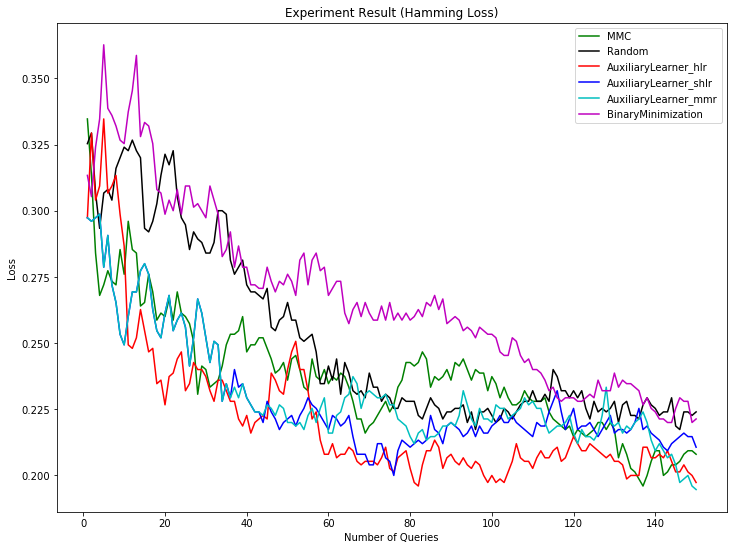

In [24]:
# multilabel active learning algorithms: 
#   1) Binary Minimization (BinMin)
#   2) Maximal Loss Reduction with Maximal Confidence (MMC)
#   3) Multilabel Active Learning With Auxiliary Learner (MLALAL)
#   NOT 4) Adaptive Active Learning (multilabel/adaptive_active_learning.py)

# BinMin calculates the uncertainty of each label independently

# MMC and MLALAL computes the uncertainty through evaluating the difference between predictions from 
# two different multilabel classifiers
# MMC uses two multilabel classifiers: binary relevance and stacked logistic regression. 
# The formula of evaluating the difference in prediction fixed.
# MLALAL is a more generalized version, we are able to freely assign multilabel classifiers

# Query Criteria (i.e. options for evaluating the difference in prediction):
# 1) Hamming Loss Reduction (HLR)
# 2) Soft Hamming Loss Reduction (SHLR)
# 3) Maximum Margin Reduction (MMR)


trn_ds, tst_ds, fully_labeled_trn_ds = split_train_test(test_size=0.25, num_labelled=5)

trn_ds2 = copy.deepcopy(trn_ds)
trn_ds3 = copy.deepcopy(trn_ds)
trn_ds4 = copy.deepcopy(trn_ds)
trn_ds5 = copy.deepcopy(trn_ds)
trn_ds6 = copy.deepcopy(trn_ds)

# lbr simulates an oracle (method label(x) returns x's label)
lbr = IdealLabeler(fully_labeled_trn_ds)

# This is the model which we train and use for predictions. It divides the task into multiple binary tasks, 
# training one classifier for each label. Unlike OvA and OvR BinaryRelevance does not use one classifier 
# for each possible value for the label
model = BinaryRelevance(LogisticRegression())

quota = 150  # number of samples to query

print "before qs1"
# MMC requires a 'base learner' for its binary relevance (to measure the uncertainty?)
qs = MMC(trn_ds, br_base=LogisticRegression())
E_out_1 = run(trn_ds, tst_ds, lbr, model, qs, quota)

print "before qs2"

qs2 = RandomSampling(trn_ds2)
E_out_2 = run(trn_ds2, tst_ds, lbr, model, qs2, quota)


print "before qs3"

# Can I replace BinaryRelevance(LogisticRegression()) with model
# MLALAL requires two multilabel models: 
# 1) major_learner, that gives a binary output on each label and is used for final prediction; 
# 2) auxiliary_learner, to estimate the confident on each label, it should give a real value output 
#     (supports pred_real method)

qs3 = MultilabelWithAuxiliaryLearner(
    trn_ds3,
    BinaryRelevance(LogisticRegression()),
    BinaryRelevance(SVM()),
    criterion='hlr')
E_out_3 = run(trn_ds3, tst_ds, lbr, model, qs3, quota)

print "before qs4"

qs4 = MultilabelWithAuxiliaryLearner(
    trn_ds4,
    BinaryRelevance(LogisticRegression()),
    BinaryRelevance(SVM()),
    criterion='shlr')
E_out_4 = run(trn_ds4, tst_ds, lbr, model, qs4, quota)

print "before qs5"

qs5 = MultilabelWithAuxiliaryLearner(
    trn_ds5,
    BinaryRelevance(LogisticRegression()),
    BinaryRelevance(SVM()),
    criterion='mmr')
E_out_5 = run(trn_ds5, tst_ds, lbr, model, qs5, quota)

print "before qs6"
# BinMin only needs a Continuous Model to eveluate uncertainty
qs6 = BinaryMinimization(trn_ds6, LogisticRegression())
E_out_6 = run(trn_ds6, tst_ds, lbr, model, qs6, quota)

print "Done qs6"

query_num = np.arange(1, quota + 1)
fig = plt.figure(figsize=(12, 9)) # increase plot size
plt.plot(query_num, E_out_1, 'g', label='MMC')
plt.plot(query_num, E_out_2, 'k', label='Random')
plt.plot(query_num, E_out_3, 'r', label='AuxiliaryLearner_hlr')
plt.plot(query_num, E_out_4, 'b', label='AuxiliaryLearner_shlr')
plt.plot(query_num, E_out_5, 'c', label='AuxiliaryLearner_mmr')
plt.plot(query_num, E_out_6, 'm', label='BinaryMinimization')

plt.title('Experiment Result (Hamming Loss)')
plt.xlabel('Number of Queries')
plt.ylabel('Loss')
plt.legend()
plt.show()



